# Load Data

In [8]:
import os
import sys

feat_dir = os.path.join('..', 'ML_Forex_Forecasting')
sys.path.append(feat_dir)

In [9]:
import pandas as pd
from generate_features import generate_features

In [10]:
usd_eur = pd.read_csv(os.path.join(feat_dir, "./USDEUR=X.csv"), parse_dates=['Date'])
usd_gbp = pd.read_csv(os.path.join(feat_dir, "./USDGBP=X.csv"), parse_dates=['Date'])
usd_chf = pd.read_csv(os.path.join(feat_dir, "./USDCHF=X.csv"), parse_dates=['Date'])
eur_gbp = pd.read_csv(os.path.join(feat_dir, "./EURGBP=X.csv"), parse_dates=['Date'])
eur_chf = pd.read_csv(os.path.join(feat_dir, "./EURCHF=X.csv"), parse_dates=['Date'])
gbp_chf = pd.read_csv(os.path.join(feat_dir, "./GBPCHF=X.csv"), parse_dates=['Date'])
print(f"USD/EUR: {usd_eur.shape}")
display(usd_eur.head())

USD/EUR: (283, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-05,1.00157,1.01673,1.00058,1.00157,1.00157,0
1,2022-10-06,1.00898,1.02152,1.00742,1.00898,1.00898,0
2,2022-10-07,1.02155,1.02757,1.01874,1.02155,1.02155,0
3,2022-10-10,1.02722,1.03279,1.02540,1.02722,1.02722,0
4,2022-10-11,1.02986,1.03370,1.02479,1.02986,1.02986,0


In [11]:
usd_eur_feats = generate_features(usd_eur)
print(f"USD/EUR Features shape: {usd_eur_feats.shape}")
display(usd_eur_feats.head())


USD/EUR Features shape: (261, 28)


,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-03,0.945199,0.996826,0.999919,-0.000297,0.946022,0.229700,0.939270,1.043171,0.229004,...,-41.111287,-54.398803,-61.313050,-4993.021989,47.614688,-10.622861,0.005791,0.005406,47.614688,0.94170
1,2023-11-02,0.945213,1.000000,1.000076,0.000419,0.945956,-0.177821,0.994201,0.262652,-0.178594,...,-9.290272,-20.339210,-50.912016,-6094.045172,51.275082,-0.483403,0.006837,0.006782,51.275082,0.94455
2,2023-11-01,0.945341,1.004797,0.999876,-0.000406,0.945648,-0.039596,0.966074,0.217502,-0.040345,...,72.033089,23.415789,-55.779281,-5456.625850,52.203439,2.113941,0.006873,0.006781,52.203439,0.94526
3,2023-10-31,0.944310,1.000000,1.000519,-0.004140,0.945353,-0.095383,1.141647,-2.449326,-0.097118,...,-51.355597,-1217.312478,-73.096569,-5475.101600,48.284815,-9.476169,0.006578,0.006271,48.284815,0.94206
4,2023-10-30,0.943330,1.000000,0.999855,0.002468,0.945113,0.498747,1.097032,-5.987184,-0.499811,...,2.010633,36.868278,2.814554,-5448.023078,54.348909,7.278908,0.007783,0.007933,54.348909,0.94675


# 1. Prepare X_train, Y_train, X_test, Y_test

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# use the past 20 days to train the model
def prepare_train_test(df: pd.DataFrame, n_lag_features: int = 10, test_size: float = 0.2, n_days_ahead: int = 5):
    df = df.copy()
    df.drop(['t'], axis=1)
    XY = []
    
    for col in df.columns:
        if col == 'Close':
            closes = pd.DataFrame()
            for i in range(1, n_days_ahead + 1):
                lag_feature_name = f'{col}_Day_{i}'
                closes[lag_feature_name] = df[col].shift(i)
            XY.append(closes)
        elif col != 'Date':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            XY.append(col_lag_features)
    df = pd.concat(XY, axis=1)
    df.dropna(inplace=True)
    
    Y_columns = [f'{col}_Day_{i}' for i in range(1, n_days_ahead + 1)]
    Y = df[Y_columns]
    X = df.drop(columns=Y_columns, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [14]:
n_days_ahead = 5 # predict the next 5 days
n_lag_features = 10 # how many past days used for predictions

In [15]:
X_train, X_test, Y_train, Y_test = prepare_train_test(usd_eur_feats, n_lag_features=n_lag_features, n_days_ahead=n_days_ahead)

In [16]:
X_train.head()

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
159,0.927793,0.931973,0.937004,0.938198,0.937529,0.937707,0.937385,0.938638,0.941807,0.943060,...,44.542185,40.099363,37.222580,42.396816,45.834130,48.530244,53.248306,55.659431,44.915793,45.099413
216,0.939084,0.937741,0.938590,0.939411,0.939997,0.940732,0.940630,0.941358,0.942622,0.942166,...,45.172073,49.796265,36.641597,32.695621,35.874312,38.103390,37.190890,36.857488,33.926378,37.742525
123,0.913983,0.910952,0.909396,0.907986,0.906878,0.907617,0.907697,0.907682,0.908119,0.908176,...,56.549908,58.672306,54.167599,47.860079,49.559508,46.711141,44.642522,44.264474,40.178291,43.956536
200,0.919404,0.921478,0.923144,0.924022,0.924590,0.924288,0.924230,0.925722,0.927055,0.930200,...,34.700951,31.272323,33.264689,34.092682,34.626228,36.424570,38.587454,38.858758,35.455199,35.730777
245,0.967975,0.968577,0.966919,0.965807,0.965887,0.968777,0.976165,0.981923,0.987343,0.995762,...,33.837413,33.230569,37.387014,40.350158,34.036899,31.633077,29.057411,30.238492,31.481820,30.845503


In [17]:
X_train.columns.tolist()

['opt_sine_offset_Lag_0',
 'opt_sine_offset_Lag_1',
 'opt_sine_offset_Lag_2',
 'opt_sine_offset_Lag_3',
 'opt_sine_offset_Lag_4',
 'opt_sine_offset_Lag_5',
 'opt_sine_offset_Lag_6',
 'opt_sine_offset_Lag_7',
 'opt_sine_offset_Lag_8',
 'opt_sine_offset_Lag_9',
 'opt_sine_amp_Lag_0',
 'opt_sine_amp_Lag_1',
 'opt_sine_amp_Lag_2',
 'opt_sine_amp_Lag_3',
 'opt_sine_amp_Lag_4',
 'opt_sine_amp_Lag_5',
 'opt_sine_amp_Lag_6',
 'opt_sine_amp_Lag_7',
 'opt_sine_amp_Lag_8',
 'opt_sine_amp_Lag_9',
 'opt_sine_freq_Lag_0',
 'opt_sine_freq_Lag_1',
 'opt_sine_freq_Lag_2',
 'opt_sine_freq_Lag_3',
 'opt_sine_freq_Lag_4',
 'opt_sine_freq_Lag_5',
 'opt_sine_freq_Lag_6',
 'opt_sine_freq_Lag_7',
 'opt_sine_freq_Lag_8',
 'opt_sine_freq_Lag_9',
 'opt_sine_phase_Lag_0',
 'opt_sine_phase_Lag_1',
 'opt_sine_phase_Lag_2',
 'opt_sine_phase_Lag_3',
 'opt_sine_phase_Lag_4',
 'opt_sine_phase_Lag_5',
 'opt_sine_phase_Lag_6',
 'opt_sine_phase_Lag_7',
 'opt_sine_phase_Lag_8',
 'opt_sine_phase_Lag_9',
 'opt_fourier_offset

In [18]:
Y_train.head() # closing prices for the next 1-5 days

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
159,0.92532,0.92255,0.92220,0.91704,0.92564
216,0.95037,0.93841,0.93169,0.93119,0.92885
123,0.92033,0.92265,0.92804,0.92398,0.92498
200,0.91984,0.92160,0.92073,0.90803,0.91700
245,0.96455,0.96660,0.96857,0.95920,0.94981


## Scale features

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


## Reduce feature size

In [20]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_train_scaled_reduced = pca.fit_transform(X_train_scaled)
X_test_scaled_reduced = pca.transform(X_test_scaled)


## Scale Ys

In [21]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()

Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)

# 2. Train SVR

In [22]:
from sklearn.svm import SVR

import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np


In [23]:

Y_train_scaled.shape

(197, 5)

In [24]:
# svrs: [svr_d1, svr_d2, svr_d3, svr_d4, svr_d5], a model for each day
svrs = []
for i in range(0, n_days_ahead):
    svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    svr.fit(X_train_scaled_reduced, Y_train_scaled[:, i])
    svrs.append(svr)

In [25]:
pred_train = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_train[f'Close_Day_{i}'] = svrs[i-1].predict(X_train_scaled_reduced)
pred_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,-0.197940,-0.197389,-0.301403,-0.508252,-0.153840
1,0.492753,0.379031,0.311123,0.233291,0.156801
2,-0.309581,-0.224389,-0.015357,-0.067027,0.098649
3,-0.441978,-0.429748,-0.336455,-0.462401,-0.509831
4,2.252868,2.395938,2.430208,1.971536,1.554799
...,...,...,...,...,...
192,0.374407,0.392917,0.481720,0.617368,0.436691
193,1.248322,1.293159,1.409385,1.464120,1.493850
194,-0.973827,-0.888779,-0.834109,-0.794785,-0.725102
195,0.675241,0.789340,0.923488,0.967949,0.974712


In [26]:
mse = mean_squared_error(Y_train_scaled, pred_train)
mse

0.06607787766797849

In [27]:
# transform back to the original scale
Y_train_pred = scaler_y.inverse_transform(pred_train)
mse = mean_squared_error(Y_train, Y_train_pred)
mse

1.6498047333344723e-05

In [28]:
Y_train

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
159,0.92532,0.92255,0.92220,0.91704,0.92564
216,0.95037,0.93841,0.93169,0.93119,0.92885
123,0.92033,0.92265,0.92804,0.92398,0.92498
200,0.91984,0.92160,0.92073,0.90803,0.91700
245,0.96455,0.96660,0.96857,0.95920,0.94981
...,...,...,...,...,...
111,0.92930,0.93470,0.93355,0.93475,0.93393
19,0.94528,0.94297,0.94124,0.94906,0.95043
97,0.90970,0.91250,0.91687,0.91655,0.91264
184,0.93610,0.93879,0.94288,0.94357,0.94744


In [29]:
Y_train_pred

array([[0.92372331, 0.92370761, 0.92193446, 0.91861501, 0.92408951],
       [0.9347792 , 0.93288882, 0.93161707, 0.9302819 , 0.92892245],
       [0.92193628, 0.92327756, 0.92645618, 0.92555691, 0.92801773],
       [0.91981701, 0.92000661, 0.92138037, 0.9193364 , 0.918551  ],
       [0.96295327, 0.96501404, 0.96511481, 0.95763017, 0.95067249],
       [0.91390792, 0.90952339, 0.90500457, 0.90121866, 0.89998737],
       [0.91752611, 0.91733204, 0.91786583, 0.91896109, 0.9154268 ],
       [0.93849775, 0.93751752, 0.93784439, 0.93904838, 0.93921757],
       [0.92385391, 0.92261421, 0.9215276 , 0.91696215, 0.91662066],
       [0.92415403, 0.92277706, 0.91862526, 0.92406971, 0.91795445],
       [0.89179963, 0.89080741, 0.89213435, 0.89425313, 0.89946053],
       [0.91848794, 0.91632296, 0.91196012, 0.91008959, 0.90637923],
       [0.93224389, 0.93076249, 0.92819611, 0.92700236, 0.9264082 ],
       [0.91997816, 0.92110468, 0.92375706, 0.92317721, 0.92229141],
       [0.9088024 , 0.90913977, 0.

In [30]:
pred_test = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    pred_test[f'Close_Day_{i}'] = svrs[i-1].predict(X_test_scaled_reduced)
pred_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.323757,0.467807,0.549963,0.630374,0.778151
1,1.105211,1.033155,1.211147,1.331340,1.291850
2,0.595006,0.707988,0.838256,0.804449,0.743397
3,-0.882849,-0.804455,-0.618088,-0.591970,-0.656277
4,-0.201756,-0.284924,-0.194236,-0.332297,-0.381114
5,0.795380,0.811312,0.900338,0.951228,1.064937
6,-0.441950,-0.527037,-0.371864,-0.319555,-0.379763
7,0.443456,0.471212,0.297006,0.288339,0.140119
8,1.187282,1.380698,1.306069,1.273352,1.236956
9,1.440938,1.233140,1.226432,1.407184,1.327501


In [31]:
mse = mean_squared_error(Y_test_scaled, pred_test)
mse

0.13781881242135055

In [32]:
# transform back to the original scale
Y_test_pred = scaler_y.inverse_transform(pred_test)
mse = mean_squared_error(Y_test, Y_test_pred)
mse

3.44953438378855e-05

In [33]:
Y_test

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
38,0.92995,0.93160,0.94010,0.93736,0.93522
11,0.94460,0.94429,0.93722,0.94381,0.94632
186,0.93758,0.93594,0.93610,0.93879,0.94288
91,0.92013,0.91680,0.91633,0.91870,0.92110
160,0.92780,0.92532,0.92255,0.92220,0.91704
183,0.93879,0.94288,0.94357,0.94744,0.94240
199,0.92160,0.92073,0.90803,0.91700,0.92671
109,0.93355,0.93475,0.93393,0.92741,0.93015
14,0.94748,0.94580,0.94890,0.94460,0.94429
239,0.95266,0.95520,0.95118,0.94700,0.95037


In [34]:
Y_test_pred

array([[0.93207408, 0.93430285, 0.93539255, 0.93652932, 0.93858941],
       [0.94458278, 0.94330769, 0.94584433, 0.94755779, 0.94658153],
       [0.93641595, 0.93812844, 0.9399498 , 0.93926808, 0.93804871],
       [0.91276   , 0.91403829, 0.91692841, 0.91729785, 0.91627259],
       [0.92366223, 0.92231336, 0.92362852, 0.92138336, 0.92055358],
       [0.93962333, 0.93977417, 0.94093117, 0.94157739, 0.94305122],
       [0.91981745, 0.918457  , 0.92082064, 0.92158382, 0.9205746 ],
       [0.9339901 , 0.93435707, 0.9313939 , 0.93114799, 0.92866291],
       [0.94589649, 0.94884334, 0.94734481, 0.94664545, 0.94572749],
       [0.94995674, 0.94649304, 0.94608595, 0.94875107, 0.94713619],
       [0.9511425 , 0.948903  , 0.94619251, 0.94546163, 0.94365341],
       [0.9322444 , 0.93208461, 0.93196135, 0.93162794, 0.93150939],
       [0.95805448, 0.95528784, 0.95181671, 0.95075244, 0.95149439],
       [0.93878292, 0.94248486, 0.93942546, 0.94027476, 0.94232208],
       [0.91028295, 0.91214685, 0.

In [35]:
df_test_pred_d1 = pd.DataFrame(Y_test_pred[:,0], Y_test.index)

In [36]:
df_test_pred_d1 = df_test_pred_d1.sort_index()

In [37]:
df_test = Y_test.sort_index()

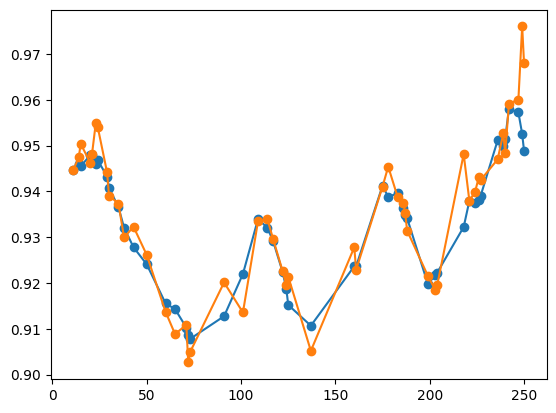

In [38]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_1'], marker='o')

In [39]:
df_test_pred_d2 = pd.DataFrame(Y_test_pred[:,1], Y_test.index)

In [40]:
df_test_pred_d2 = df_test_pred_d2.sort_index()

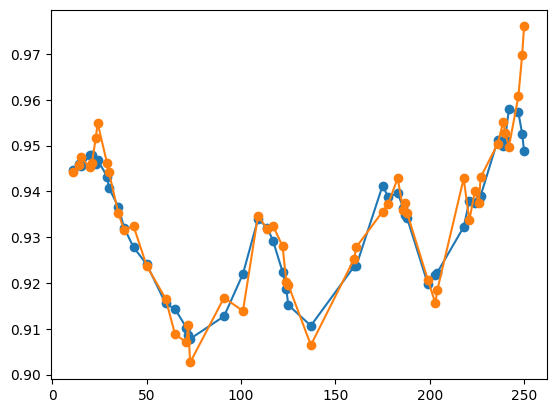

In [41]:
import matplotlib.pyplot as plt
plt.plot(df_test_pred_d1, marker='o')
plt.plot(df_test['Close_Day_2'], marker='o')

# Predict next 5 days

In [51]:
usd_eur_feats

,Date,opt_sine_offset,opt_sine_amp,opt_sine_freq,opt_sine_phase,opt_fourier_offset,opt_fourier_cosamp,opt_fourier_cosfreq,opt_fourier_cosphase,opt_fourier_sinamp,...,ROC1,ROC5,ROC20,WILLIAMS14,RSI14,CMO9,DEMA9,TEMA9,STOCH14,Close
0,2023-11-03,0.945199,0.996826,0.999919,-0.000297,0.946022,0.229700,0.939270,1.043171,0.229004,...,-41.111287,-54.398803,-61.313050,-4993.021989,47.614688,-10.622861,0.005791,0.005406,47.614688,0.94170
1,2023-11-02,0.945213,1.000000,1.000076,0.000419,0.945956,-0.177821,0.994201,0.262652,-0.178594,...,-9.290272,-20.339210,-50.912016,-6094.045172,51.275082,-0.483403,0.006837,0.006782,51.275082,0.94455
2,2023-11-01,0.945341,1.004797,0.999876,-0.000406,0.945648,-0.039596,0.966074,0.217502,-0.040345,...,72.033089,23.415789,-55.779281,-5456.625850,52.203439,2.113941,0.006873,0.006781,52.203439,0.94526
3,2023-10-31,0.944310,1.000000,1.000519,-0.004140,0.945353,-0.095383,1.141647,-2.449326,-0.097118,...,-51.355597,-1217.312478,-73.096569,-5475.101600,48.284815,-9.476169,0.006578,0.006271,48.284815,0.94206
4,2023-10-30,0.943330,1.000000,0.999855,0.002468,0.945113,0.498747,1.097032,-5.987184,-0.499811,...,2.010633,36.868278,2.814554,-5448.023078,54.348909,7.278908,0.007783,0.007933,54.348909,0.94675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2022-11-10,1.008965,1.030443,0.999187,0.002250,1.014185,-0.634673,0.956146,-1.718646,0.632337,...,11.165805,-25.660454,-34.641107,-2121.490672,43.080414,-16.548267,0.061957,0.059817,43.080414,0.99805
257,2022-11-09,1.012550,1.000000,0.999468,0.002850,1.015010,0.883457,0.950804,4.237072,0.884958,...,-10.178049,-27.266985,-41.729014,-2467.225277,38.634120,-28.051637,0.063992,0.061698,38.634120,0.99198
258,2022-11-08,1.015773,1.000000,0.999300,0.001149,1.015794,-0.756631,0.938660,4.029760,-0.755858,...,-12.983017,-18.082790,-34.387656,-2451.650056,41.704001,-20.923046,0.070001,0.069548,41.704001,0.99814
259,2022-11-07,1.014696,1.289427,1.000862,-0.005809,1.016162,-0.235063,1.089407,-2.271632,-0.235800,...,-21.019186,3.960994,-22.376632,-2428.818198,46.761831,-9.031970,0.075333,0.077147,46.761831,1.00717


In [43]:
def prepare_for_pred(df: pd.DataFrame, n_lag_features: int = 10):
    df = df.copy()
    df.drop(['t'], axis=1)
    X = []
    
    for col in df.columns:
        if col == 'Date':
            X.append(df[col])
        elif col != 'Close':
            col_lag_features = pd.DataFrame()
            for i in range(n_lag_features):
                lag_feature_name = f'{col}_Lag_{i}'
                col_lag_features[lag_feature_name] = df[col].shift(-i)
            X.append(col_lag_features)
        
    df = pd.concat(X, axis=1)
    df.dropna(inplace=True)
    return df


In [45]:
input_feats = prepare_for_pred(usd_eur_feats, n_lag_features).iloc[[0]]
input_feats

,Date,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,2023-11-03,0.945199,0.945213,0.945341,0.94431,0.94333,0.943382,0.943288,0.944567,0.946045,...,47.614688,51.275082,52.203439,48.284815,54.348909,54.143665,53.876225,51.224183,43.272136,51.662923


In [46]:
input_feats = input_feats.drop(columns=['Date'])
input_feats

,opt_sine_offset_Lag_0,opt_sine_offset_Lag_1,opt_sine_offset_Lag_2,opt_sine_offset_Lag_3,opt_sine_offset_Lag_4,opt_sine_offset_Lag_5,opt_sine_offset_Lag_6,opt_sine_offset_Lag_7,opt_sine_offset_Lag_8,opt_sine_offset_Lag_9,...,STOCH14_Lag_0,STOCH14_Lag_1,STOCH14_Lag_2,STOCH14_Lag_3,STOCH14_Lag_4,STOCH14_Lag_5,STOCH14_Lag_6,STOCH14_Lag_7,STOCH14_Lag_8,STOCH14_Lag_9
0,0.945199,0.945213,0.945341,0.94431,0.94333,0.943382,0.943288,0.944567,0.946045,0.947567,...,47.614688,51.275082,52.203439,48.284815,54.348909,54.143665,53.876225,51.224183,43.272136,51.662923


In [47]:
input_feats_scaled = scaler.transform(input_feats)

In [48]:
input_feats_scaled_reduced = pca.transform(input_feats_scaled)

In [49]:
preds_scaled = pd.DataFrame()
for i in range(1, n_days_ahead + 1):
    preds_scaled[f'Close_Day_{i}'] = svrs[i-1].predict(input_feats_scaled_reduced)
preds_scaled

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.763974,0.973554,1.022201,0.911146,0.877642


In [50]:
preds_unscaled = scaler_y.inverse_transform(preds_scaled)

In [52]:
pd.DataFrame(preds_unscaled, columns=preds_scaled.columns)

,Close_Day_1,Close_Day_2,Close_Day_3,Close_Day_4,Close_Day_5
0,0.939121,0.942358,0.942858,0.940947,0.940137


In [ ]:
outfile = 'predictions_T_svr.csv'

# Save the NumPy matrix to the CSV file (append mode)
with open(outfile, 'a') as f:
    np.savetxt(f, preds_unscaled, delimiter=',')